In [1]:
import pandas as pd
import numpy as np
path = "ECAI"

def get_intersection(v01, ve1, v02, ve2, max_weight=10):
    # handle division by zero masking out the positions where the denominator is zero
    denominator = ve2 - ve1
    if isinstance(denominator, np.ndarray):
        denominator[denominator == 0] = np.nan
    else:
        if denominator == 0:
            return np.nan
    wes = (v01 - v02) / denominator
    return np.round(wes[(wes >= 0) & (wes <= max_weight)], 2)


In [2]:
# Proper wes calculation
from value_vectors import map2file

eff_rates = [0.2, 0.4, 0.6, 0.8]
dbs = [10, 1000]

we = np.zeros((len(eff_rates), len(dbs), 10))
we_std = np.zeros((len(eff_rates), len(dbs)))
we_median = np.zeros((len(eff_rates), len(dbs)))

for eff_rate in eff_rates:
    for db in dbs:
        unethical = np.load(map2file[eff_rate][0])
        unethical_np = unethical.reshape(-1, 500, 5, 2).mean(axis=1)
        
        ethical = np.load(map2file[eff_rate][db])
        ethical_np = ethical.reshape(-1, 500, 5, 2).mean(axis=1)

        wes = []
        for i in range(unethical_np.shape[0]):
            wag = []
            for ag in range(5):
                max_weight = 10
                w = get_intersection(unethical_np[i, ag, 0], unethical_np[i, ag, 1], ethical_np[i, ag, 0], ethical_np[i, ag, 1], max_weight=max_weight)
                if not np.isnan(w).all():
                    wag.append(w)
            if np.isnan(wag).all():
                continue
            wes.append(np.max(wag))
        if len(wes) == 0:
            continue

        we[eff_rates.index(eff_rate), dbs.index(db)] = np.array(wes)
        """we[eff_rates.index(eff_rate), dbs.index(db)] = np.array(wes).mean(axis=0).squeeze()
        we_std[eff_rates.index(eff_rate), dbs.index(db)] = np.array(wes).std(axis=0).squeeze()
        we_median[eff_rates.index(eff_rate), dbs.index(db)] = np.median(np.array(wes), axis=0).squeeze()"""
we[eff_rates.index(0.2), :].mean(axis=1)

array([1.439, 1.617])

In [3]:
we[eff_rates.index(0.2), :].std(axis=1)

array([0.0304795 , 0.02830194])

In [4]:
np.median(we[eff_rates.index(0.4), :], axis=1)

array([2.17, 1.84])

In [5]:
# Print as latex row for table with standard deviation
for eff_rate in [0.2, 0.4, 0.6, 0.8]:
    print(f"{int(eff_rate*100)}\% & ", end="")
    for db in [10, 1000]:
        mean = we[eff_rates.index(eff_rate), dbs.index(db)].mean().round(2)
        std = we[eff_rates.index(eff_rate), dbs.index(db)].std().round(2)
        if db == 100:
            print(f"{mean} \\pm {std} ", end="")
        else:
            print(f"{mean} \\pm {std} & ", end="")
    print("\\\\")

20\% & 1.44 \pm 0.03 & 1.62 \pm 0.03 & \\
40\% & 2.19 \pm 0.1 & 1.84 \pm 0.03 & \\
60\% & 1.99 \pm 0.19 & 1.81 \pm 0.05 & \\
80\% & 1.52 \pm 0.38 & 1.27 \pm 0.07 & \\


Agent, 		 ref[0],	 ref[1],	 unet[0],	 unet[1]
Agent 	0, 	29.71, 	6.27, 	36.79, 	0.0
Agent 	1, 	29.86, 	6.58, 	36.48, 	0.0
Agent 	2, 	29.98, 	6.03, 	36.94, 	0.0
Agent 	3, 	29.6, 	6.2, 	37.52, 	0.0
Agent 	4, 	-16.0, 	0.0, 	-26.73, 	0.0
[1.13]
[1.01]
[1.15]
[1.28]
nan


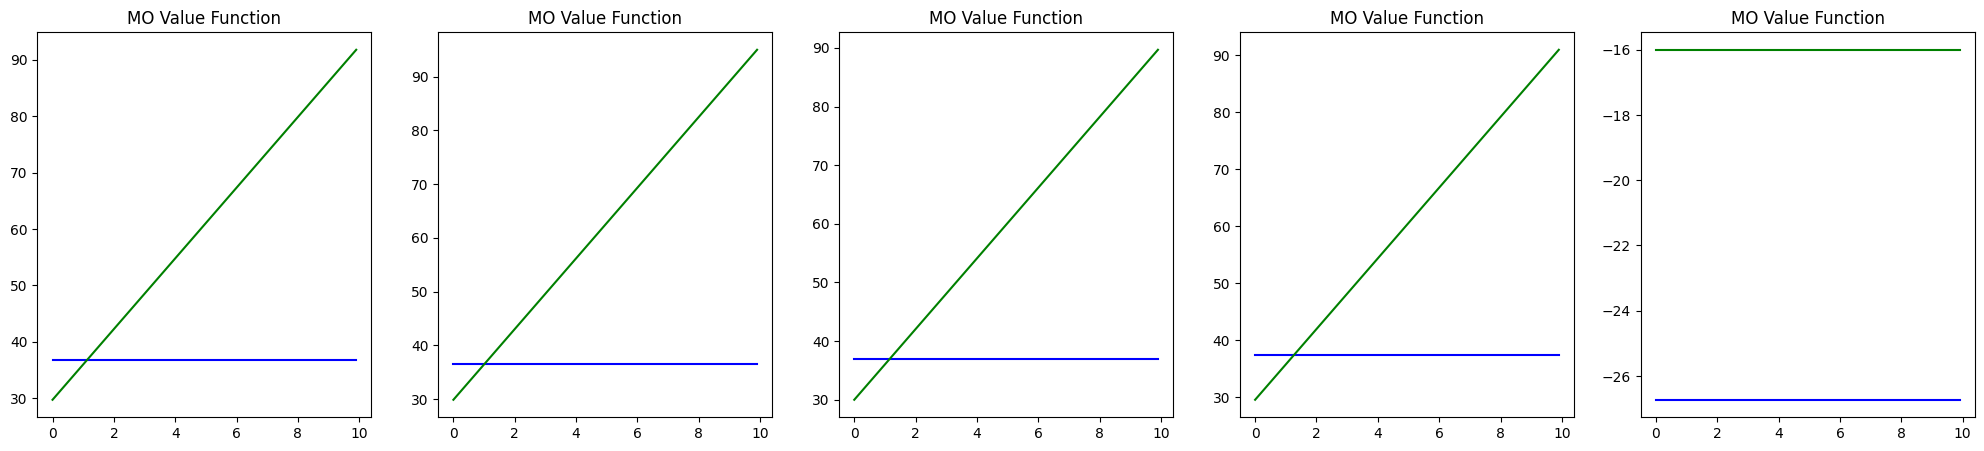

In [15]:
# Playground wes calculation
from value_vectors import *
import matplotlib.pyplot as plt
import  matplotlib
# matplotlib.use("Qt5Agg")

#ref = policies[0.4][10]
ref = np.array([ [29.71, 6.27],[29.86, 6.58],[29.98, 6.03],[29.6, 6.2],[-16.0, 0.0] ])
unet = np.array([ [36.79, -0.0],[36.48, -0.0],[36.94, 0.0],[37.52, 0.0],[-26.73, -0.02] ])

unet[:, 1] = 0 

fig, axs = plt.subplots(1, 5, figsize=(25, 5)) 
step = 0.1
# for ag in mo_value_w10:
max_weight = 10
# Subplot for each agent
x = np.arange(0, max_weight, step)
w = np.array([np.ones(int(max_weight/step)), np.arange(0, max_weight, step)])

print("Agent, \t\t ref[0],\t ref[1],\t unet[0],\t unet[1]")
for i, ag in enumerate(range(5)):
    # Print lines like: Agent i, ref[0], ref[1], unet[0], unet[1]
    print(f"Agent \t{ag}, \t{ref[ag, 0]}, \t{ref[ag, 1]}, \t{unet[ag, 0]}, \t{unet[ag, 1]}")

for i, ag in enumerate(range(5)):
    axs[i].set_title("MO Value Function")
    axs[i].plot(x, np.dot(unet[ag], w), c="blue")
    axs[i].plot(x, np.dot(ref[ag], w), c="green")
    
wes = []
for ag in range(5):
    # Print intersecctions
    inter = get_intersection(unet[ag, 0], unet[ag, 1], ref[ag, 0], ref[ag, 1], max_weight=max_weight)
    print(inter)
    wes.append(inter)
plt.show()

In [13]:
# Brute search wes. All possible permutations of same-group agents
eff_rate = 0.8 # Percentage of ethical agents
ref = np.array([ [28.95, 6.01],[30.28, 6.59],[29.64, 6.13],[30.73, 6.21],[-16.0, 0.00]])
unet = np.array([ [36.79, -0.0],[36.48, -0.0],[36.94, 0.0],[37.52, 0.0],[-26.73, -0.02] ])
# Call get_intersection for all possible permutations of agents from the same group
n_eff = int(eff_rate*5)
wes = []
for i in range(n_eff):
    for j in range(i+1, n_eff):
        inter = get_intersection(unet[i, 0], unet[i, 1], ref[j, 0], ref[j, 1], max_weight=10)
        if not np.isnan(inter).all():
            print(f"Agent {i} and {j}: {inter} \t\t {unet[i]} \t {ref[j]}")
            wes.append(inter)
print(sorted(wes, reverse=True))

Agent 0 and 1: [0.99] 		 [36.79 -0.  ] 	 [30.28  6.59]
Agent 0 and 2: [1.17] 		 [36.79 -0.  ] 	 [29.64  6.13]
Agent 0 and 3: [0.98] 		 [36.79 -0.  ] 	 [30.73  6.21]
Agent 1 and 2: [1.12] 		 [36.48 -0.  ] 	 [29.64  6.13]
Agent 1 and 3: [0.93] 		 [36.48 -0.  ] 	 [30.73  6.21]
Agent 2 and 3: [1.] 		 [36.94  0.  ] 	 [30.73  6.21]
[array([1.17]), array([1.12]), array([1.]), array([0.99]), array([0.98]), array([0.93])]


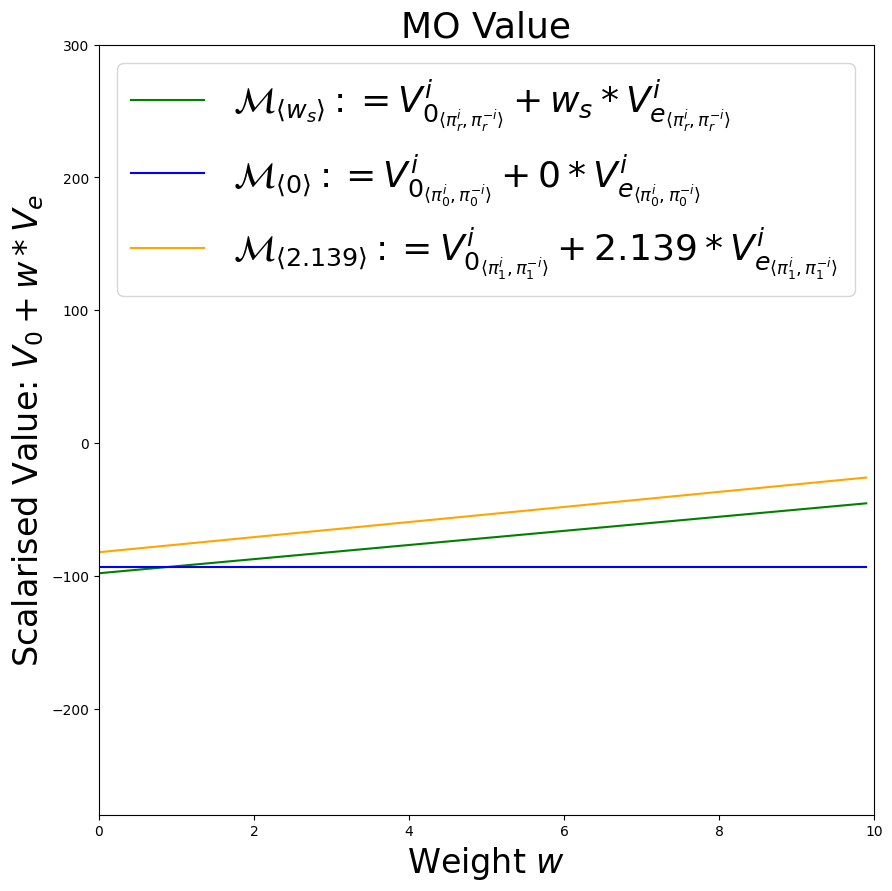

In [8]:
# Ploting for paper
from value_vectors import validations, policies
import matplotlib.pyplot as plt
import  matplotlib
#matplotlib.use("TkAgg")

ref = policies[0.8][10]
unet = policies[0.8][0]
middle = validations[0.8][10]

plt.figure(figsize=(10, 10))

ag = 0

step = 0.1
# for ag in mo_value_w10:
max_weight = 10

x = np.arange(0, max_weight, step)
w = np.array([np.ones(int(max_weight/step)), np.arange(0, max_weight, step)])

plt.title("MO Value", fontsize=26)
plt.xlim(0, max_weight)
plt.ylim(-280, 300)
plt.plot(x, np.dot(ref[ag], w), c="green", label="$\mathcal{M}_{\langle w_s \\rangle} := V^i_{0_{\langle \pi^i_r, \pi^{-i}_r \\rangle}} + w_s * V^i_{e_{\langle \pi^i_r, \pi^{-i}_r \\rangle}}$ ")
plt.plot(x, np.dot(unet[ag], w), c="blue", label="$\mathcal{M}_{\langle 0 \\rangle} := V^i_{0_{\langle \pi^i_0, \pi^{-i}_0 \\rangle}} + 0 * V^i_{e_{\langle \pi^i_0, \pi^{-i}_0 \\rangle}}$")

plt.xlabel("Weight $w$", fontsize=24)
plt.ylabel("Scalarised Value: $V_0 + w * V_e$", fontsize=24)
if middle is not None:
    plt.plot(x, np.dot(middle[ag], w), c="orange", label="$\mathcal{M}_{\langle 2.139 \\rangle} := V^i_{0_{\langle \pi^i_1, \pi^{-i}_1 \\rangle}} + 2.139 * V^i_{e_{\langle \pi^i_1, \pi^{-i}_1 \\rangle}}$ ")

# Print intersecctions
#inter = get_intersection(unet[ag, 0], unet[ag, 1], ref[ag, 0], ref[ag, 1], max_weight=max_weight)
#inter = [1, inter[0]]

# Plot a red dot on intersection
#plt.scatter(inter[1], np.dot(ref[ag], inter), c="red", s=100, label="Intersection")

# Plot a black dashed line from the intersection to the x axis
#plt.plot([inter[1], inter[1]], [np.dot(ref[ag], inter), -300], c="black", linestyle="--")

# add intersection to x ticks
#plt.xticks(list(plt.xticks()[0]) + [inter[1]])
plt.legend(fontsize=26, loc="upper left")
plt.show()

In [9]:
# Use kmeans. 
from sklearn.cluster import KMeans
import numpy as np
km1 = KMeans(n_clusters=2)
km1.fit(validations[0.8][10])
km1.cluster_centers_

km2 = KMeans(n_clusters=2)
km2.fit(policies[0.8][10])
km1.cluster_centers_

array([[ -87.02  ,    5.5325],
       [-177.81  ,    0.    ]])

In [10]:
def eval(eff_rate):
    db1 = pd.read_csv(path + folder(1, eff_rate, 10)*2  + "/mo_rewards.csv").to_numpy().reshape(-1, 500, 5, 2).mean(axis=1)[0].round(2)
    db10 = pd.read_csv(path + folder(10, eff_rate, 10)*2  + "/mo_rewards.csv").to_numpy().reshape(-1, 500, 5, 2).mean(axis=1)[0].round(2)
    db1000 = pd.read_csv(path + folder(1000, eff_rate, 10)*2  + "/mo_rewards.csv").to_numpy().reshape(-1, 500, 5, 2).mean(axis=1)[0].round(2)
    #middle = pd.read_csv(path + folder(1, 1, 10)*2  + "/mo_rewards.csv").to_numpy().reshape(-1, 500, 5, 2).mean(axis=1)[0]
    unet = pd.read_csv(path + folder(0, eff_rate, 0)*2  + "/mo_rewards.csv").to_numpy().reshape(-1, 500, 5, 2).mean(axis=1)[0].round(2)
    
    x = np.arange(0, max_weight, step)
    w = np.array([np.ones(int(max_weight/step)), np.arange(0, max_weight, step)])
    
    n = int(eff_rate*5)
    fig, axs = plt.subplots(1, n, figsize=(8*n, 5))
    axs=[axs] if n == 1 else axs
    for i in range(n):
        axs[i].set_title("MO Value Function")
        axs[i].plot(x, np.dot(unet[i], w), c="blue", label=f"UNET:=${unet[i, 0]} + w_e \cdot {unet[i, 1]}$")
        axs[i].plot(x, np.dot(db1[i], w), c="red", label=f"DB=1:=${db1[i, 0]} + w_e \cdot {db1[i, 1]}$")
        axs[i].plot(x, np.dot(db10[i], w), c="magenta", label=f"DB=10:=${db10[i, 0]} + w_e \cdot {db10[i, 1]}$")
        axs[i].plot(x, np.dot(db1000[i], w), c="cyan", label=f"DB=1000:=${db1000[i, 0]} + w_e \cdot {db1000[i, 1]}$")
    
        if middle is not None:
            plt.plot(x, np.dot(middle[i], w), c="orange")
        axs[i].set_xlabel("Weight $w_e$")
        axs[i].set_ylabel("Scalarised Value")
        axs[i].set_xlim(0, max_weight)
        axs[i].set_ylim(-520, 300)
        axs[i].legend()
        
    wes_db1 = []
    wes_db10 = []
    wes_db1000 = []
    for ag in range(n):
        # Print intersecctions
        db1_inter = get_intersection(unet[ag, 0], unet[ag, 1], db1[ag, 0], db1[ag, 1], max_weight=max_weight)
        db10_inter = get_intersection(unet[ag, 0], unet[ag, 1], db10[ag, 0], db10[ag, 1], max_weight=max_weight)
        db1000_inter = get_intersection(unet[ag, 0], unet[ag, 1], db1000[ag, 0], db1000[ag, 1], max_weight=max_weight)
        print(f"Agent {ag}: {db1_inter} \t {db10_inter} \t {db1000_inter}")
        
        wes_db1.append(0 if len(db1_inter) == 0 else db1_inter[0])
        
        
            
    print(f"DB 1: \t\tMax: {np.max(wes_db1).round(2)}, Mean: {np.mean(wes_db1).round(2)}, Std: {np.std(wes_db1).round(2)}, Median: {np.median(wes_db1).round(2)}")
    print(f"DB 10: \t\tMax: {np.max(wes_db10).round(2)}, Mean: {np.mean(wes_db10).round(2)}, Std: {np.std(wes_db10).round(2)}, Median: {np.median(wes_db10).round(2)}")
    print(f"DB 1000: \tMax: {np.max(wes_db1000).round(2)}, Mean: {np.mean(wes_db1000).round(2)}, Std: {np.std(wes_db1000).round(2)}, Median: {np.median(wes_db1000).round(2)}")

    
    plt.show()
folder = lambda db, eff, we : f"/db{db}_effrate{eff}_we{we}_ECAI_new"

eff_rate = 0.8
eval(eff_rate)

FileNotFoundError: [Errno 2] No such file or directory: 'ECAI/db10_effrate0.8_we10_ECAI_new/db10_effrate0.8_we10_ECAI_new/mo_rewards.csv'

[1, 4.76]


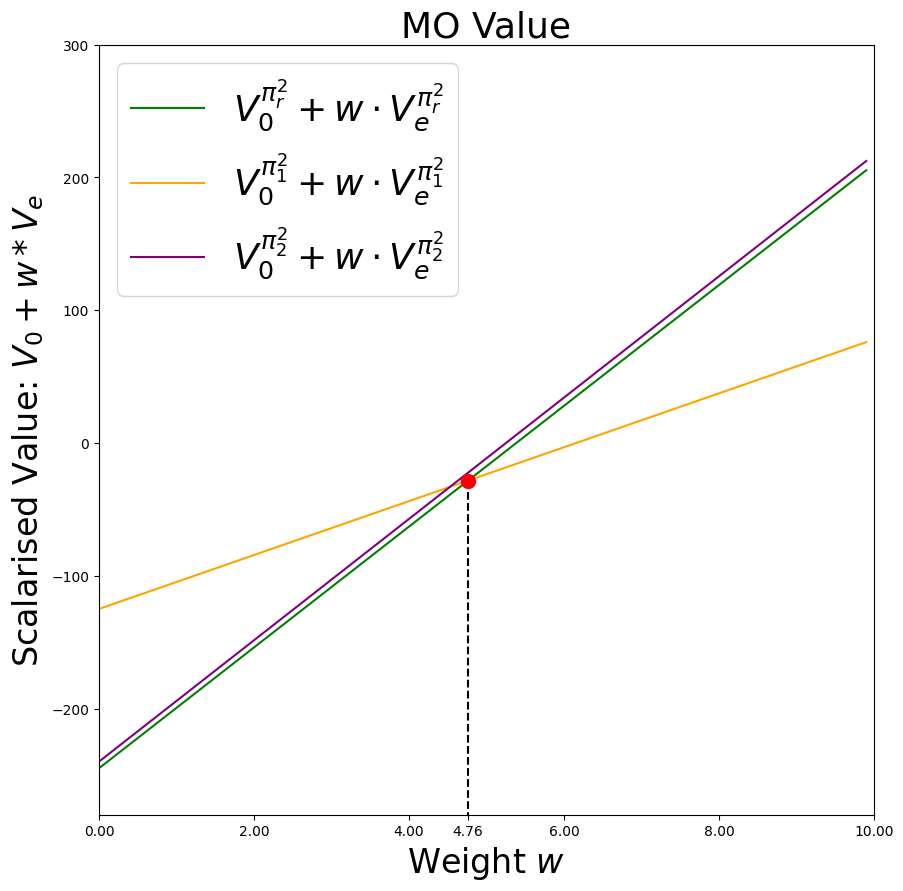

In [30]:
# Ploting for paper
from value_vectors import validations, policies
import matplotlib.pyplot as plt
import  matplotlib
#matplotlib.use("TkAgg")

middle = np.array([[-130, 15.92], [-125, 20.3]])
unet = None#np.array([[-90, 0.5], [-89, 0.6]])
ref = np.array([[-250, 40.5], [-245, 45.5]])
val = np.array([[-235, 41.2], [-240, 45.7]])

plt.figure(figsize=(10, 10))

ag = 1

step = 0.1
# for ag in mo_value_w10:
max_weight = 10

x = np.arange(0, max_weight, step)
w = np.array([np.ones(int(max_weight/step)), np.arange(0, max_weight, step)])

plt.title("MO Value", fontsize=26)
plt.xlim(0, max_weight)
plt.ylim(-280, 300)

label = "$V_0^{\pi^"+ str(ag+1) +"_r} + w \cdot V_e^{\pi^"+ str(ag+1) +"_r}$"
plt.plot(x, np.dot(ref[ag], w), c="green", label=label)

if unet is not None:
    label = "$V_0^{\pi^"+ str(ag+1) +"_0} + w \cdot V_e^{\pi^"+ str(ag+1) +"_0}$"
    plt.plot(x, np.dot(unet[ag], w), c="blue", label=label)

plt.xlabel("Weight $w$", fontsize=24)
plt.ylabel("Scalarised Value: $V_0 + w * V_e$", fontsize=24)
if middle is not None:
    label = "$V_0^{\pi^"+ str(ag+1) +"_1} + w \cdot V_e^{\pi^"+ str(ag+1) +"_1}$"
    plt.plot(x, np.dot(middle[ag], w), c="orange", label=label)
    
if val is not None:
    label = "$V_0^{\pi^"+ str(ag+1) +"_2} + w \cdot V_e^{\pi^"+ str(ag+1) +"_2}$"
    plt.plot(x, np.dot(val[ag], w), c="purple", label=label)

tiks = list(plt.xticks()[0])

# Print intersecctions
if unet is not None:
    inter = get_intersection(unet[ag, 0], unet[ag, 1], ref[ag, 0], ref[ag, 1], max_weight=max_weight)
    inter = [1, inter[0]]
    tiks.append(inter[1])
    print(inter)
    
    # Plot a red dot on intersection
    plt.scatter(inter[1], np.dot(ref[ag], inter), c="red", s=100, zorder=10)
    
    # Plot a black dashed line from the intersection to the x axis
    plt.plot([inter[1], inter[1]], [np.dot(ref[ag], inter), -300], c="black", linestyle="--")

if middle is not None:
    inter = get_intersection(middle[ag, 0], middle[ag, 1], ref[ag, 0], ref[ag, 1], max_weight=max_weight)
    inter = [1, inter[0]]
    tiks.append(inter[1])
    print(inter)
    
    # Plot a red dot on intersection
    plt.scatter(inter[1], np.dot(ref[ag], inter), c="red", s=100, zorder=10)

    # Plot a black dashed line from the intersection to the x axis
    plt.plot([inter[1], inter[1]], [np.dot(ref[ag], inter), -300], c="black", linestyle="--")
    
#add intersection to x ticks
plt.xticks(tiks)
plt.legend(fontsize=26, loc="upper left")
plt.show()

[1, 4.0]
[1, 4.88]
['0', '2', '4', '6', '8', '10', '4', '4.88']
[1, 3.47]
[1, 4.76]
['0', '2', ' ', '6', '8', '10', '3.47', '4.76']


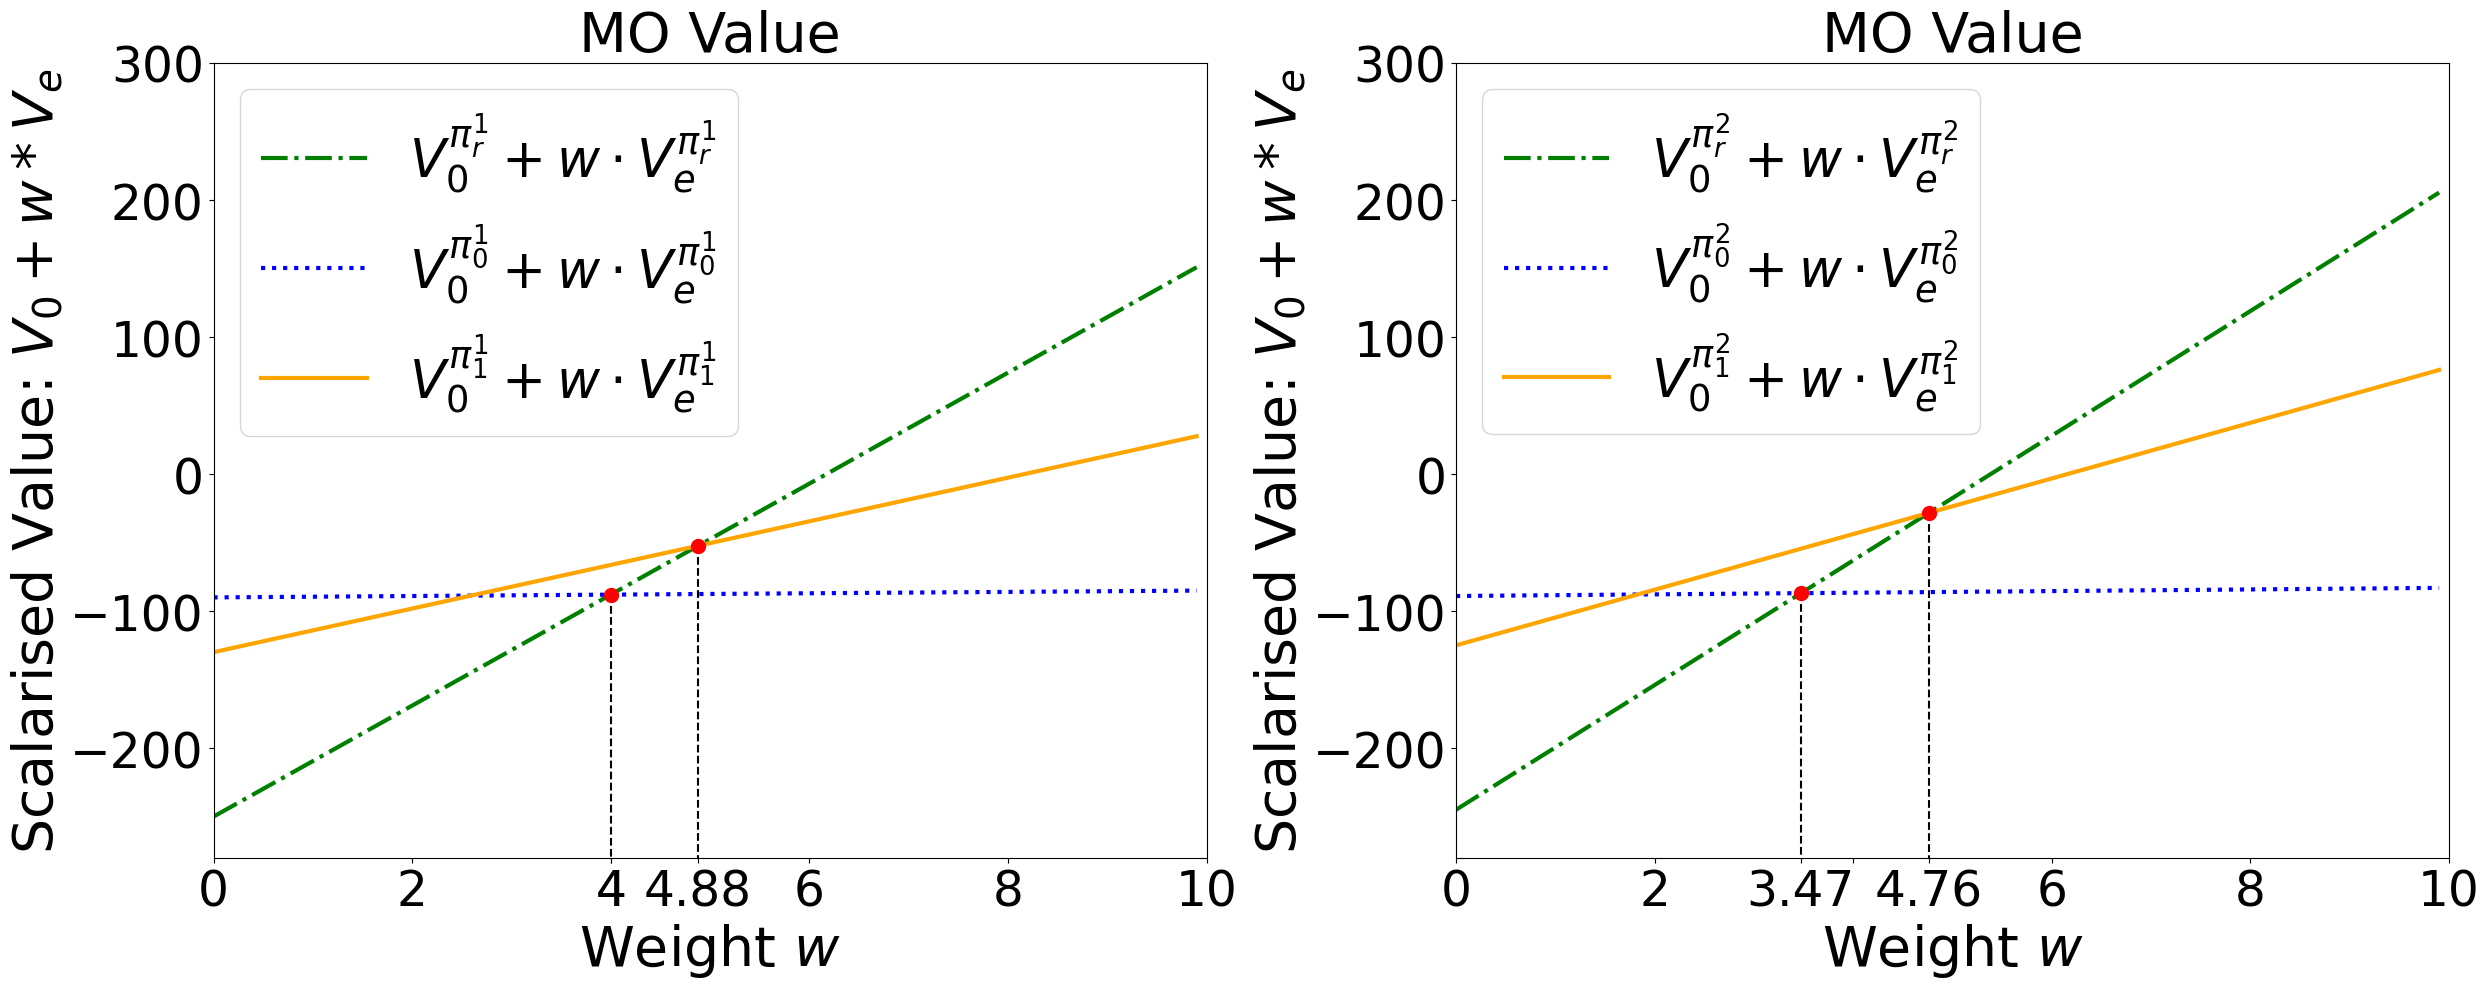

In [25]:
# Ploting for paper
from value_vectors import validations, policies
import matplotlib.pyplot as plt
import  matplotlib
#matplotlib.use("TkAgg")

middle = np.array([[-130, 15.92], [-125, 20.3]])
unet = np.array([[-90, 0.5], [-89, 0.6]])
ref = np.array([[-250, 40.5], [-245, 45.5]])
val = None#np.array([[-235, 41.2], [-240, 45.7]])

fig, ax = plt.subplots(1, 2, figsize=(25, 10))

for ag in range(2):
    plt.subplot(1, 2, ag+1)
    axs = ax[ag]
    step = 0.1
    # for ag in mo_value_w10:
    max_weight = 10
    
    x = np.arange(0, max_weight, step)
    w = np.array([np.ones(int(max_weight/step)), np.arange(0, max_weight, step)])
    
    plt.title("MO Value", fontsize=40)
    plt.xlim(0, max_weight)
    plt.ylim(-280, 300)
    
    label = "$V_0^{\pi^"+ str(ag+1) +"_r} + w \cdot V_e^{\pi^"+ str(ag+1) +"_r}$"
    plt.plot(x, np.dot(ref[ag], w), c="green", label=label, linestyle="-.", linewidth=3)
    
    if unet is not None:
        label = "$V_0^{\pi^"+ str(ag+1) +"_0} + w \cdot V_e^{\pi^"+ str(ag+1) +"_0}$"
        plt.plot(x, np.dot(unet[ag], w), c="blue", label=label, linestyle="dotted", linewidth=3)
    
    
    plt.xlabel("Weight $w$", fontsize=40)
    plt.ylabel("Scalarised Value: $V_0 + w * V_e$", fontsize=40)
    
    
    if middle is not None:
        label = "$V_0^{\pi^"+ str(ag+1) +"_1} + w \cdot V_e^{\pi^"+ str(ag+1) +"_1}$"
        plt.plot(x, np.dot(middle[ag], w), c="orange", label=label, linestyle="solid", linewidth=3)
        
    if val is not None:
        label = "$V_0^{\pi^"+ str(ag+1) +"_2} + w \cdot V_e^{\pi^"+ str(ag+1) +"_2}$"
        plt.plot(x, np.dot(val[ag], w), c="purple", label=label, linestyle="-.", linewidth=3)
    
    tiks = list(plt.xticks()[0])
    
    # Print intersecctions
    if unet is not None:
        inter = get_intersection(unet[ag, 0], unet[ag, 1], ref[ag, 0], ref[ag, 1], max_weight=max_weight)
        inter = [1, inter[0]]
        tiks.append(inter[1])
        print(inter)
        
        # Plot a red dot on intersection
        plt.scatter(inter[1], np.dot(ref[ag], inter), c="red", s=100, zorder=10)
        
        # Plot a black dashed line from the intersection to the x axis
        plt.plot([inter[1], inter[1]], [np.dot(ref[ag], inter), -300], c="black", linestyle="--")
    
    if middle is not None:
        inter = get_intersection(middle[ag, 0], middle[ag, 1], ref[ag, 0], ref[ag, 1], max_weight=max_weight)
        inter = [1, inter[0]]
        tiks.append(inter[1])
        print(inter)
        
        # Plot a red dot on intersection
        plt.scatter(inter[1], np.dot(ref[ag], inter), c="red", s=100, zorder=10)
    
        # Plot a black dashed line from the intersection to the x axis
        plt.plot([inter[1], inter[1]], [np.dot(ref[ag], inter), -300], c="black", linestyle="--")
        
    # set tiks as str and put it without decimals if they are integers
    tiks_labels = [str(int(t)) if (t == round(t, 0)) else str(t) for t in tiks]
    if ag == 1:
        tiks_labels[tiks_labels.index("4")] = " "
    
    print(tiks_labels)
    plt.xticks(tiks)
    axs.set_xticklabels(tiks_labels, fontsize=35)
    plt.yticks(fontsize=35)
    plt.legend(fontsize=38, loc="upper left")
plt.tight_layout()
plt.savefig("ols.png", dpi=100)
plt.show()